<a href="https://colab.research.google.com/github/Danna-Bustacara/-Dimplomado_Ciencia_Datos/blob/main/Metro_Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.12.0
Pandas Version: 1.5.3
Numpy Version: 1.22.4
System Version: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
Pasajeros=Pasajeros2=pd.read_excel("/content/drive/Shareddrives/Eduardo1/Pasajeros-metro.xlsx", names=['Fecha', 'NumPas'])
Pasajeros['Fecha']=pd.to_datetime(Pasajeros['Fecha'])
Pasajeros=Pasajeros.set_index('Fecha')
print(type(Pasajeros))

Pasajeros_ts=Pasajeros['NumPas']
print(type(Pasajeros_ts))
Pasajeros_ts.index.freq='D'

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [5]:
df=Pasajeros

In [6]:
features_considered = ['NumPas']

In [7]:
features = df[features_considered]
features.head()

,NumPas
Fecha,
2021-01-01,31911
2021-01-02,76962
2021-01-03,162698
2021-01-04,380294
2021-01-05,389083


array([<Axes: xlabel='Fecha'>], dtype=object)

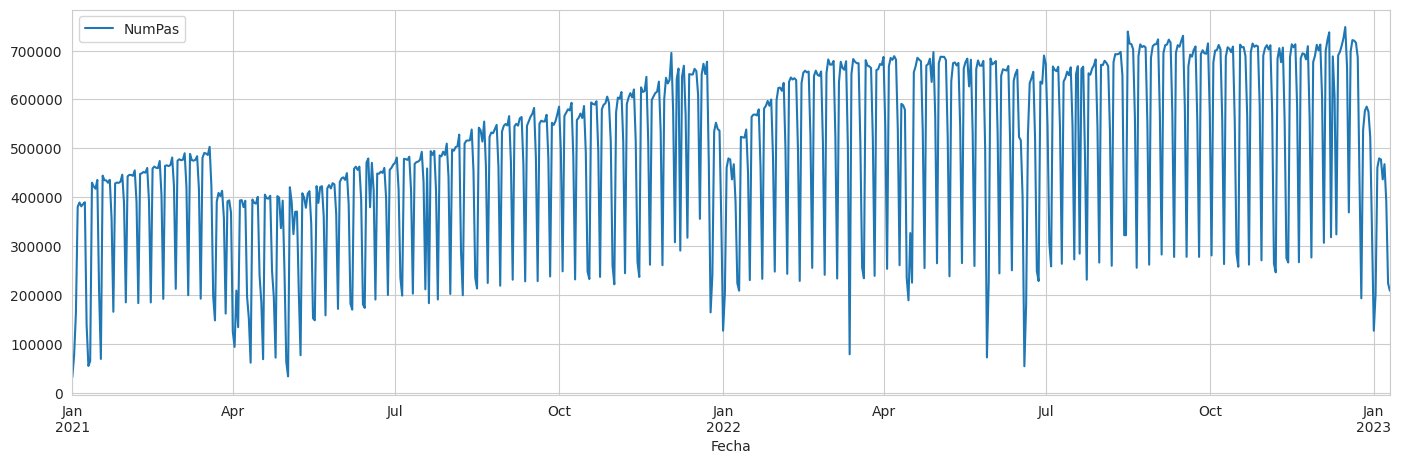

In [8]:
features.plot(subplots=True)

In [9]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [10]:
print(len(train_df))
print(len(val_df ))
print(len(test_df ))

518
148
74


In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [12]:
train_df

,NumPas
Fecha,
2021-01-01,-2.600029
2021-01-02,-2.325920
2021-01-03,-1.804267
2021-01-04,-0.480324
2021-01-05,-0.426848
...,...
2022-05-29,-2.356099
2022-05-30,-1.414938
2022-05-31,1.366458


In [13]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (518, 1)
longitud dataframe validación: (148, 1)
longitud dataframe prueba: (74, 1)


In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=130,)  ####  tamaño del lote

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
def plot(self, model=None, plot_col='NumPas', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
MAX_EPOCHS = 50 ### numero de epocas

def compile_and_fit(model, window, patience=0):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

<ipython-input-20-90e8a7e88651>:1: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  plot_acf(features,lags=21,unbiased=False)


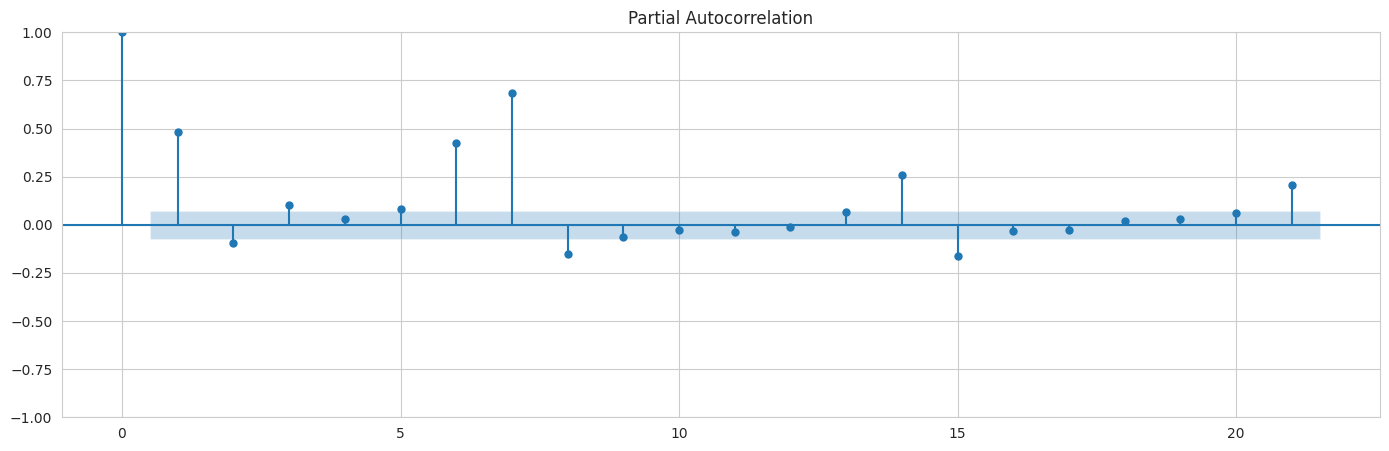

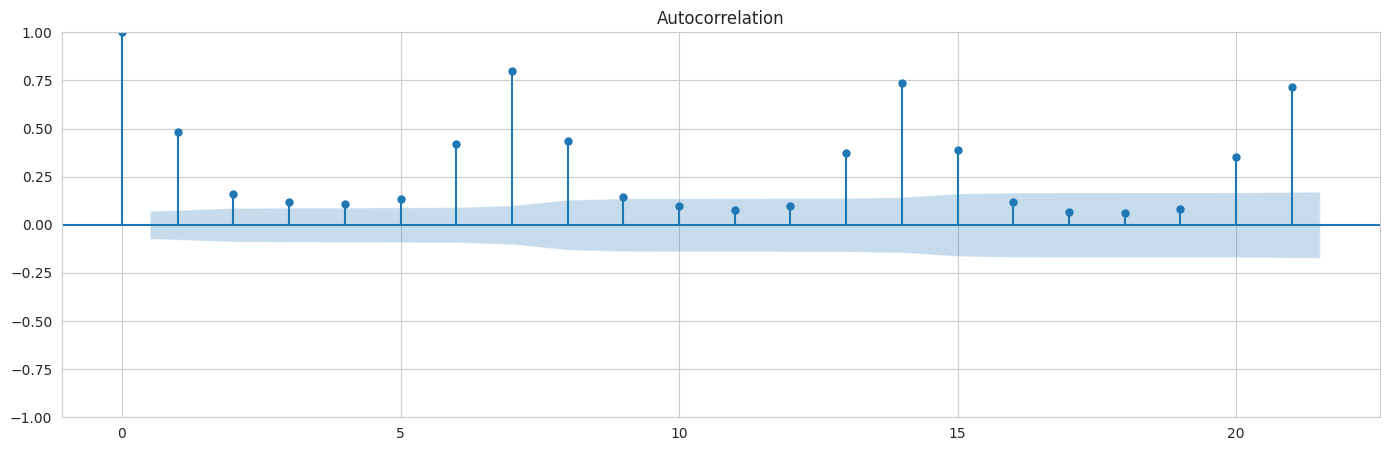

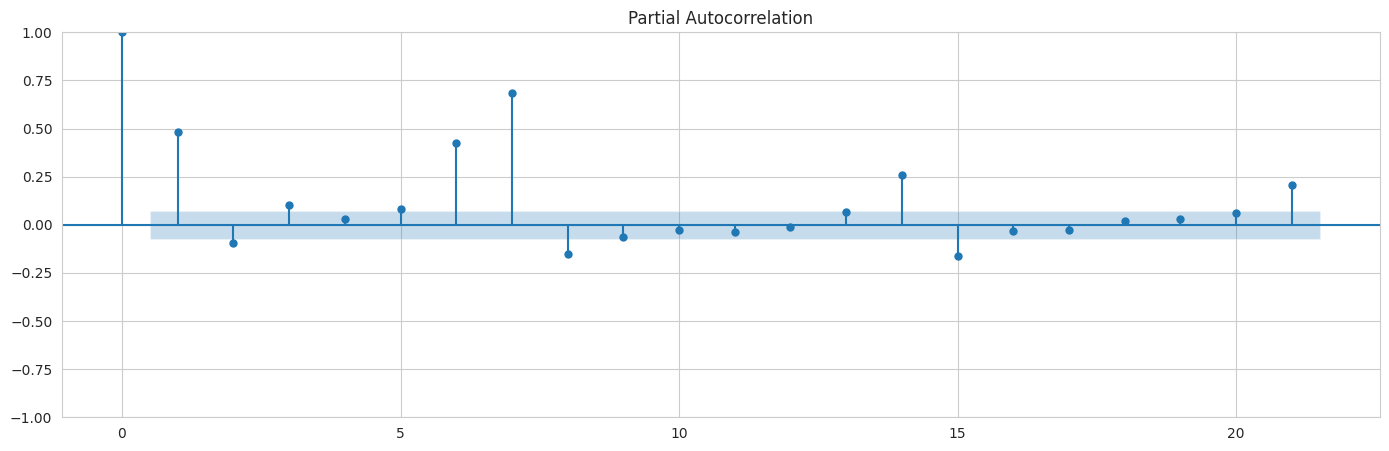

In [20]:
plot_acf(features,lags=21,unbiased=False)
plot_pacf(features,lags=21,method='ldbiased')

**Definiendo la ventana**

Dada la naturaleza de la serie, los rezagos que se deberian considerar serian 7 o 14. Por esa razón se fija un input de 14, para un shift para pasos adelante de 6 y esperando sólo una predicción.

In [21]:
## label_width=1
## shift=6  pasos adelante
single_step_window = WindowGenerator(
    input_width=14, label_width=1, shift=6,
    label_columns=['NumPas'])# La variable a predecir
single_step_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [19]
Label column name(s): ['NumPas']

In [22]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

Forma(dimensión) de las entradas (batch, time, features): (130, 14, 1)
Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): (130, 1, 1)


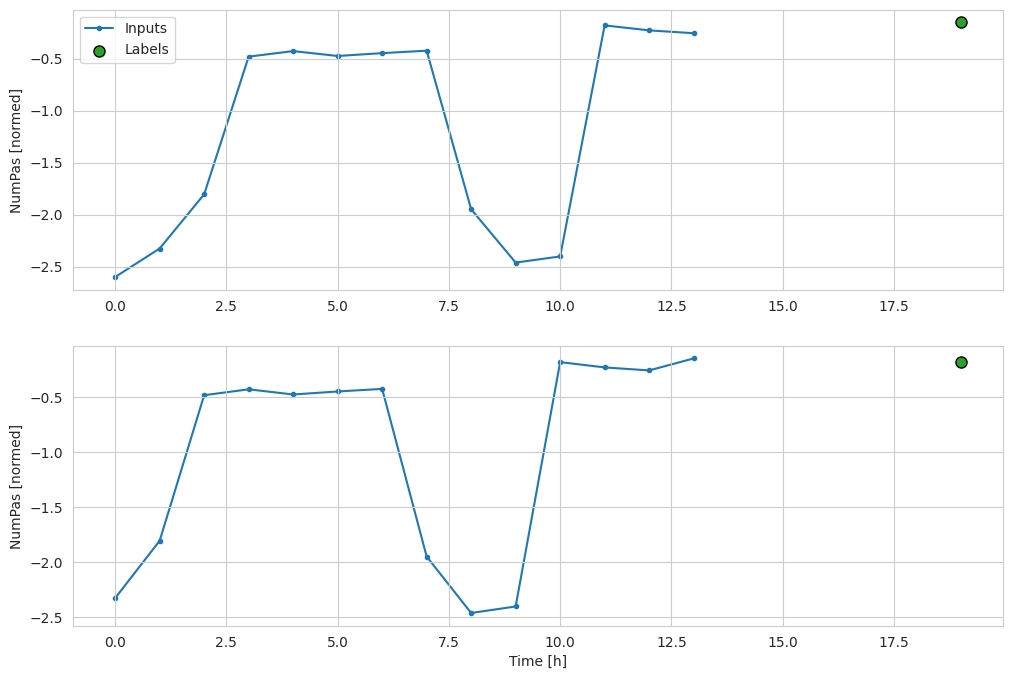

In [23]:
single_step_window.plot()

In [24]:
single_step_window
single_step_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [19]
Label column name(s): ['NumPas']

In [25]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00


In [26]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

In [27]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch


print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (130, 14, 1)
Target shape: (130, 1, 1)


In [28]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (129, 14, 1)
Target shape: (129, 1, 1)


In [29]:
len(inputs_val)
len(targets_val)

129

In [30]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)

In [31]:
input_dataset_train

<_MapDataset element_spec=TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None)>

In [32]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)

In [33]:
print(input_dataset_val)
print(target_dataset_val)

<_MapDataset element_spec=TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [34]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)

In [35]:
print(input_dataset_test)
print(target_dataset_test)

<_MapDataset element_spec=TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [36]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

In [37]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [38]:
tuner_RandomSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [39]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=1)

In [40]:
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=30, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 5 Complete [00h 00m 13s]
val_loss: 1.224708914756775

Best val_loss So Far: 1.1680444478988647
Total elapsed time: 00h 00m 55s


In [41]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
num_units: 448
activation: relu
num_layers: 4
units_0: 64
dropout: False
lr: 0.000501777635589437
units_1: 32
units_2: 32
units_3: 32
Score: 1.1680444478988647

Trial 4 summary
Hyperparameters:
num_units: 352
activation: relu
num_layers: 1
units_0: 96
dropout: False
lr: 0.00012404065397661918
units_1: 96
units_2: 64
units_3: 64
units_4: 128
Score: 1.224708914756775

Trial 2 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 5
units_0: 96
dropout: False
lr: 0.0002253374765329313
units_1: 96
units_2: 96
units_3: 64
units_4: 32
Score: 1.3859951496124268

Trial 1 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 4
units_0: 128
dropout: True
lr: 0.0004910533133090028
units_1: 128
units_2: 32
units_3: 128
Score: 1.386802077293396

Trial 3 summary
Hyperparameters:
num_units: 544
activation: tanh
num_layers: 4
un

In [42]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)###verificar que en efecto

In [43]:
train_plus_val

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [44]:
# Get the top 2 hyperparameters.
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(5)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=0)
model_mlp = build_model(best_hps_mlp[1])
# Fit with the entire dataset.
model_mlp.fit(train_plus_val, epochs=20,callbacks=[callback])

Epoch 1/20
5/5 [==============================] - 1s 31ms/step - loss: 1.1198 - mean_squared_error: 1.1198
Epoch 2/20
5/5 [==============================] - 0s 30ms/step - loss: 1.0882 - mean_squared_error: 1.0882
Epoch 3/20
5/5 [==============================] - 0s 28ms/step - loss: 1.0635 - mean_squared_error: 1.0635
Epoch 4/20
5/5 [==============================] - 0s 26ms/step - loss: 1.0422 - mean_squared_error: 1.0422
Epoch 5/20
5/5 [==============================] - 0s 30ms/step - loss: 1.0239 - mean_squared_error: 1.0239
Epoch 6/20
5/5 [==============================] - 0s 32ms/step - loss: 1.0079 - mean_squared_error: 1.0079
Epoch 7/20
5/5 [==============================] - 0s 28ms/step - loss: 0.9942 - mean_squared_error: 0.9942
Epoch 8/20
5/5 [==============================] - 0s 33ms/step - loss: 0.9825 - mean_squared_error: 0.9825
Epoch 9/20
5/5 [==============================] - 0s 32ms/step - loss: 0.9731 - mean_squared_error: 0.9731
Epoch 10/20
5/5 [====================

In [45]:
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 14, 352)           704       
                                                                 
 dense_4 (Dense)             (None, 14, 96)            33888     
                                                                 
 dense_5 (Dense)             (None, 14, 1)             97        
                                                                 
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________


In [46]:
print(model_mlp.layers[0].weights)

[<tf.Variable 'dense_3/kernel:0' shape=(1, 352) dtype=float32, numpy=
array([[-4.83927131e-02, -1.00791112e-01,  8.92678797e-02,
         7.00808018e-02,  3.32084820e-02,  1.13187373e-01,
        -7.35462606e-02, -1.82642287e-03, -3.65913771e-02,
         9.65023935e-02,  6.98217750e-02, -1.17176682e-01,
         1.12390302e-01,  5.90330698e-02, -8.71460065e-02,
         1.56325139e-02, -3.44399363e-02,  9.33422521e-02,
         9.46754962e-02, -3.87218036e-02, -9.02664568e-03,
         3.55400294e-02,  1.35722652e-01,  2.21223738e-02,
         3.69729288e-02,  1.17957741e-01, -5.51523939e-02,
         4.04899344e-02,  1.02330901e-01,  1.69019606e-02,
        -4.80012894e-02, -1.05337612e-01,  5.07514179e-02,
         3.14796604e-02, -8.19158405e-02,  2.95914430e-02,
         2.03517638e-02, -1.04835063e-01,  1.10100918e-01,
        -1.62622947e-02, -4.34946865e-02,  5.86852916e-02,
         9.64973420e-02,  5.37677202e-04,  1.19557619e-01,
        -7.20403045e-02, -1.15369670e-01,  7.

In [47]:
print(model_mlp.layers[0].bias.numpy())

[ 3.14596575e-03  5.53156808e-03 -6.57632109e-03  1.09114015e-04
  5.07935090e-03  6.99080480e-03  3.44508956e-03 -1.09845051e-03
 -2.01120134e-03  1.15430984e-03 -3.37456772e-03  3.19896126e-03
  5.74970059e-03 -4.66754008e-03 -2.91248690e-03 -5.37450099e-03
  3.12132738e-03 -1.26444653e-03 -3.29226069e-03 -2.73985579e-03
 -2.31957994e-03 -8.06149794e-04  5.38269151e-03 -4.88998601e-03
  6.11195900e-03 -2.86774104e-03 -2.92977784e-03 -3.13552329e-03
  4.90878895e-03 -6.27214415e-03 -9.09034337e-04 -3.52588110e-03
  3.95381218e-03 -6.28148345e-03 -3.20221973e-03  6.45077601e-03
  7.41892448e-03 -3.12322658e-03 -2.35797651e-03  3.39555391e-03
  3.11503420e-03  2.64122430e-03  7.14756176e-03 -2.14358070e-03
  4.51569818e-03 -4.66054492e-03  3.05300043e-03 -1.80296149e-04
  2.33894051e-03 -5.57583338e-03 -4.78721969e-03  5.91226714e-03
  5.62089914e-03  3.74566531e-03  1.56314054e-03  4.18437226e-03
  5.69608109e-03  4.58644843e-03  4.74295113e-03  4.53226129e-03
  3.87147092e-03 -5.75659

In [48]:
model_mlp.evaluate(single_step_window.test, verbose=1)

1/1 [==============================] - 0s 283ms/step - loss: 1.2602 - mean_squared_error: 1.2602


[1.2602341175079346, 1.2602341175079346]

In [49]:
model_mlp.predict(single_step_window.test).flatten()

1/1 [==============================] - 0s 326ms/step


array([ 0.35947102, -0.03921097,  0.6031811 ,  0.6395537 ,  0.6537176 ,
        0.6330742 ,  0.6534235 ,  0.3225184 , -0.039316  , -0.03989401,
        0.587433  ,  0.638975  ,  0.57120496,  0.6422243 , -0.03921097,
        0.6031811 ,  0.6395537 ,  0.6537176 ,  0.6330742 ,  0.6534235 ,
        0.3225184 , -0.039316  , -0.03989401,  0.587433  ,  0.638975  ,
        0.57120496,  0.6422243 ,  0.28102538,  0.6031811 ,  0.6395537 ,
        0.6537176 ,  0.6330742 ,  0.6534235 ,  0.3225184 , -0.039316  ,
       -0.03989401,  0.587433  ,  0.638975  ,  0.57120496,  0.6422243 ,
        0.28102538, -0.03914354,  0.6395537 ,  0.6537176 ,  0.6330742 ,
        0.6534235 ,  0.3225184 , -0.039316  , -0.03989401,  0.587433  ,
        0.638975  ,  0.57120496,  0.6422243 ,  0.28102538, -0.03914354,
       -0.03927633,  0.6537176 ,  0.6330742 ,  0.6534235 ,  0.3225184 ,
       -0.039316  , -0.03989401,  0.587433  ,  0.638975  ,  0.57120496,
        0.6422243 ,  0.28102538, -0.03914354, -0.03927633,  0.59

In [50]:
prediction_test=(model_mlp.predict(test_df, verbose=1)*train_std['NumPas']+train_mean['NumPas'])
len(prediction_test)

3/3 [==============================] - 0s 7ms/step


74

In [51]:
print(prediction_test.shape)
print(prediction_test)

(74, 1, 1)
[[[518318.12]]

 [[452792.94]]

 [[558373.  ]]

 [[564351.  ]]

 [[566678.9 ]]

 [[563286.06]]

 [[566630.56]]

 [[512244.78]]

 [[452775.7 ]]

 [[452680.7 ]]

 [[555784.7 ]]

 [[564255.9 ]]

 [[553117.56]]

 [[564789.9 ]]

 [[505425.22]]

 [[452804.03]]

 [[452782.2 ]]

 [[556928.4 ]]

 [[567383.6 ]]

 [[564987.94]]

 [[567388.7 ]]

 [[517165.9 ]]

 [[452783.47]]

 [[556072.75]]

 [[560157.5 ]]

 [[559622.3 ]]

 [[555334.1 ]]

 [[565903.56]]

 [[508991.2 ]]

 [[452806.94]]

 [[553309.94]]

 [[558187.44]]

 [[566979.44]]

 [[562521.25]]

 [[567143.5 ]]

 [[524065.6 ]]

 [[452879.78]]

 [[562041.  ]]

 [[570712.56]]

 [[576906.5 ]]

 [[452906.28]]

 [[557727.5 ]]

 [[524962.3 ]]

 [[452915.06]]

 [[558548.  ]]

 [[561331.2 ]]

 [[566360.8 ]]

 [[572317.75]]

 [[581156.9 ]]

 [[548774.06]]

 [[452944.4 ]]

 [[561507.75]]

 [[570730.06]]

 [[570249.06]]

 [[568562.4 ]]

 [[556899.1 ]]

 [[453352.84]]

 [[452382.3 ]]

 [[498721.  ]]

 [[514281.8 ]]

 [[517594.84]]

 [[513535.8 ]

In [52]:
i=1
for batch in target_dataset_test.take(130): ## numero de lotes en train
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1



In [53]:

true_series=test_df*train_std['NumPas']+train_mean['NumPas']

print(true_series.shape)

(74, 1)


In [54]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.mean()**0.5)

RECM: 191583.44145567488


Errores de predicción para el modelo

In [55]:
error_prediction_test=true_series["NumPas"]-prediction_test.reshape(-1,)

In [56]:
error_prediction_test

Fecha
2022-10-29     68944.87500
2022-10-30   -182036.93750
2022-10-31    131506.00000
2022-11-01    140864.00000
2022-11-02    144508.12500
                  ...     
2023-01-06    -17244.68750
2023-01-07      -606.84375
2023-01-08    -63021.90625
2023-01-09   -228680.53125
2023-01-10   -243801.96875
Freq: D, Name: NumPas, Length: 74, dtype: float64

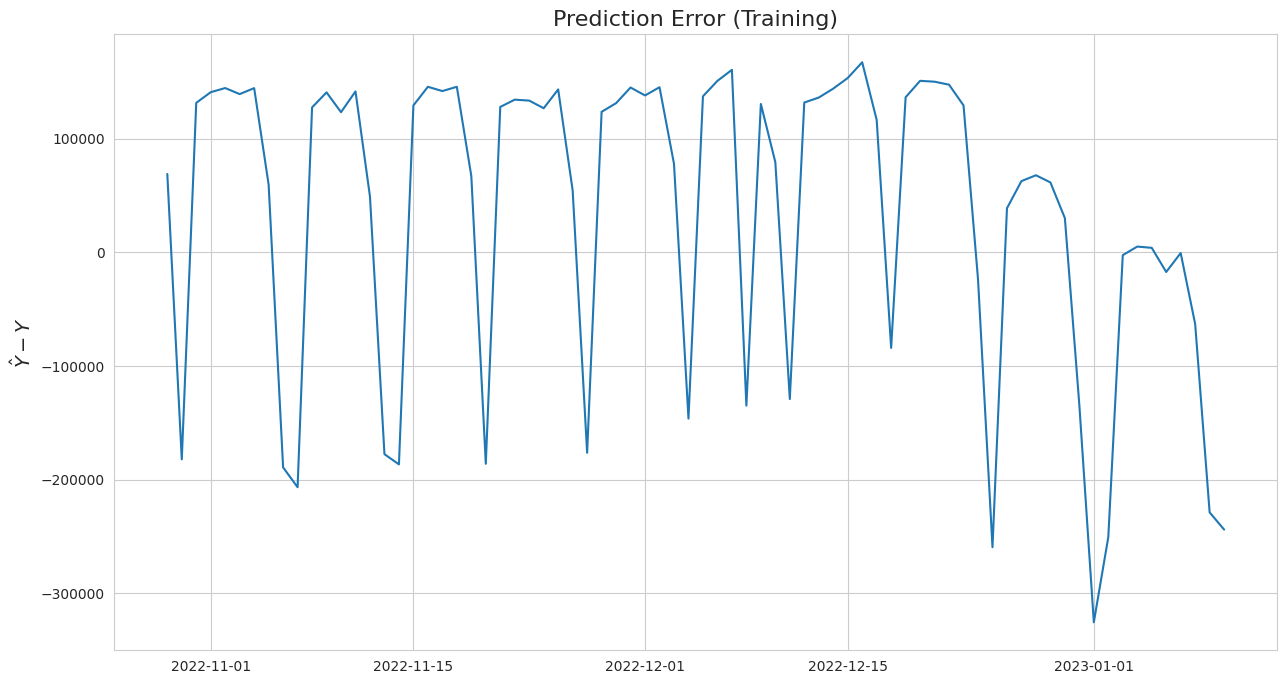

In [57]:
fig = plt.figure(figsize=(15,8))
plt.plot(error_prediction_test)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.title('Prediction Error (Training)', fontsize=16);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


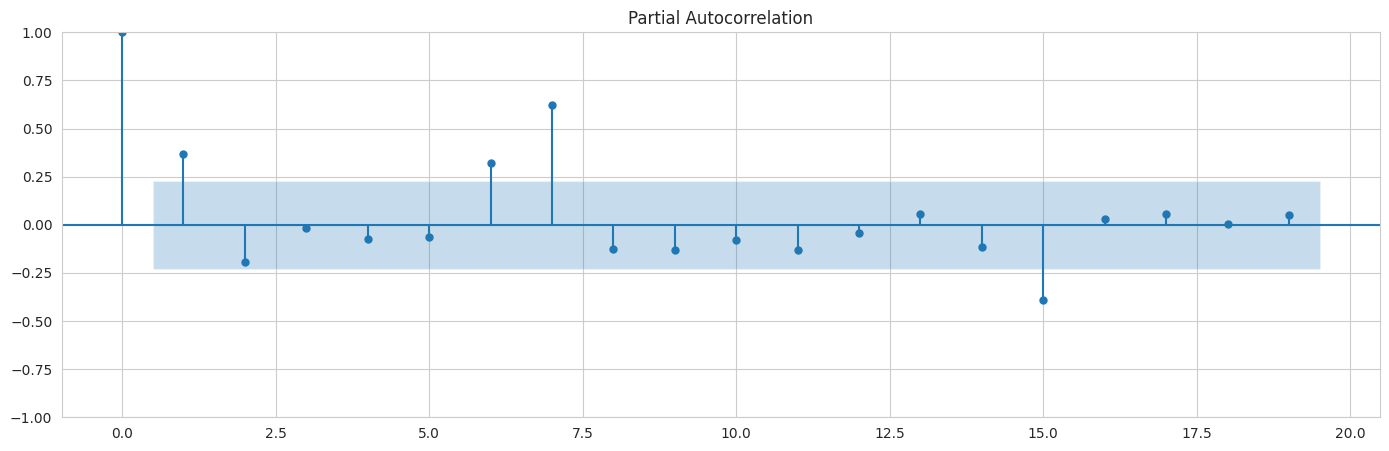

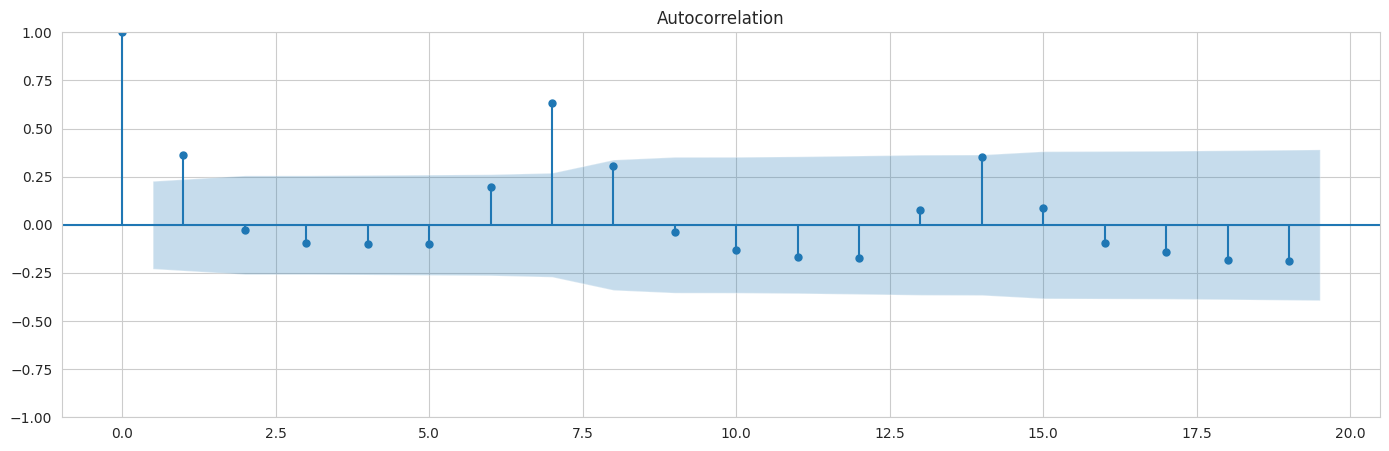

In [58]:
graficapacf=plot_pacf(error_prediction_test)
graficaacf=plot_acf(error_prediction_test)

LOs rezagos son significativos en algunos casos

Grafica para el conjunto de prueba

In [59]:
test_index=test_df.index[:74]
len(test_index.values)

74

In [60]:
true_series_final=true_series
prediction_test_final=prediction_test.reshape(-1,)

In [67]:
R=pd.DataFrame()
R["Y"]=true_series_final["NumPas"]
R["Y_esti"]=prediction_test.reshape(-1,)
R

,Y,Y_esti
Fecha,,
2022-10-29,587263.0,518318.12500
2022-10-30,270756.0,452792.93750
2022-10-31,689879.0,558373.00000
2022-11-01,705215.0,564351.00000
2022-11-02,711187.0,566678.87500
...,...,...
2023-01-06,436383.0,453627.68750
2023-01-07,467542.0,468148.84375
2023-01-08,389924.0,452945.90625


Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

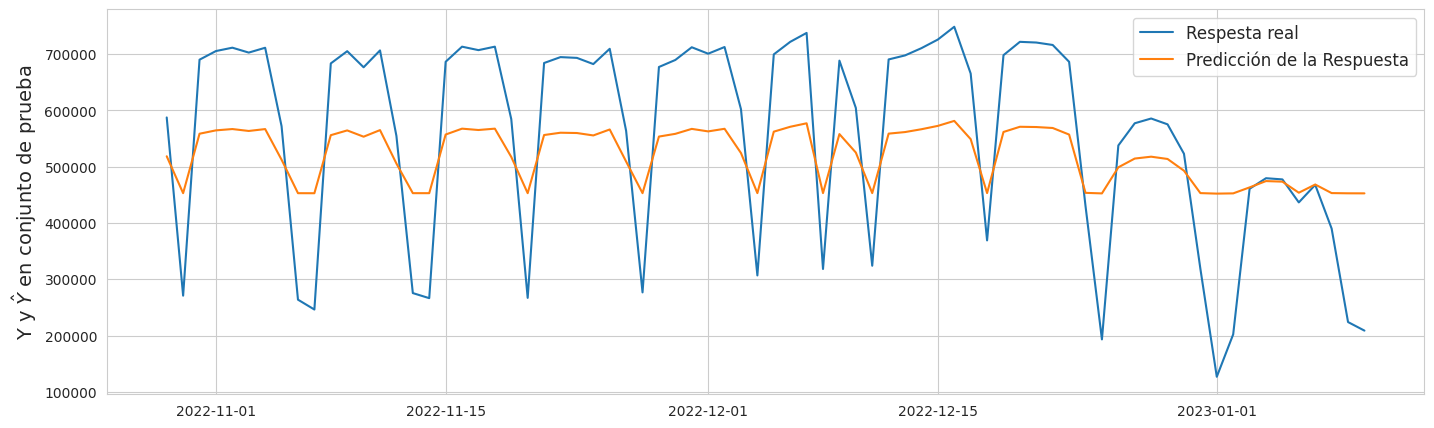

In [75]:
plt.plot(R["Y"])
plt.plot(R["Y_esti"])
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

**RESIDUALES**

In [73]:
Residuales=R['Y']-R['Y_esti']

In [74]:
Residuales

Fecha
2022-10-29     68944.87500
2022-10-30   -182036.93750
2022-10-31    131506.00000
2022-11-01    140864.00000
2022-11-02    144508.12500
                  ...     
2023-01-06    -17244.68750
2023-01-07      -606.84375
2023-01-08    -63021.90625
2023-01-09   -228680.53125
2023-01-10   -243801.96875
Freq: D, Length: 74, dtype: float64

<ipython-input-71-161ee7508874>:1: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  plot_acf(Residuales,lags=28, unbiased=False)


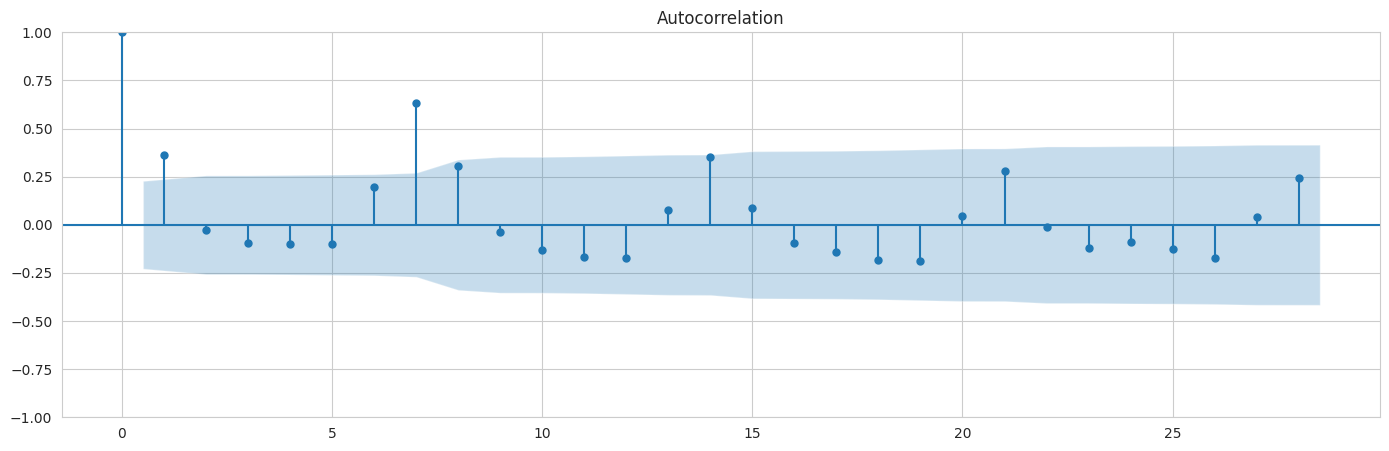

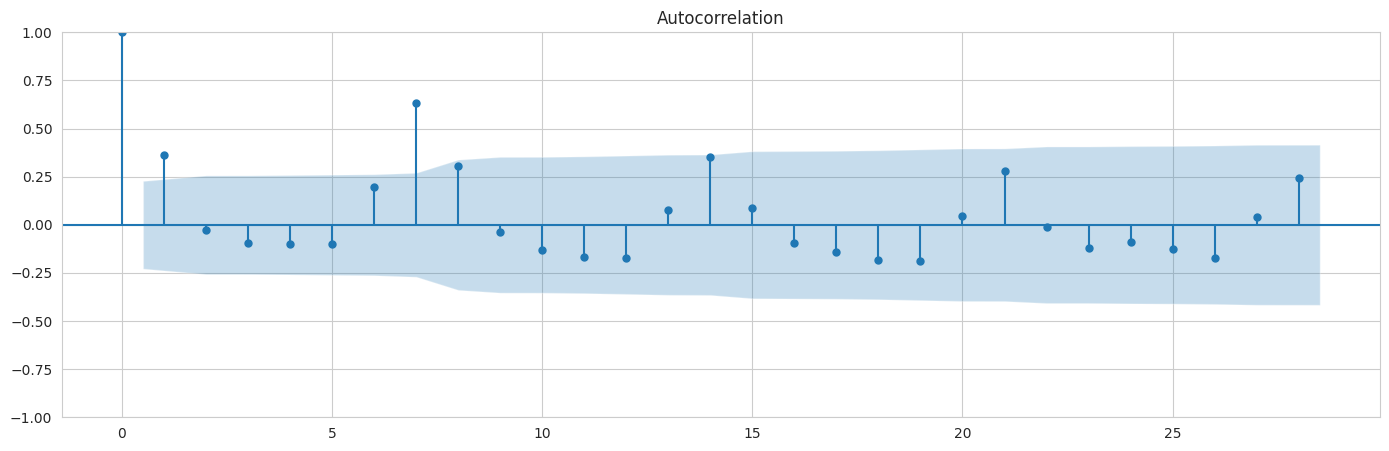

In [71]:
plot_acf(Residuales,lags=28, unbiased=False)

Text(0.5, 0, 'Index')

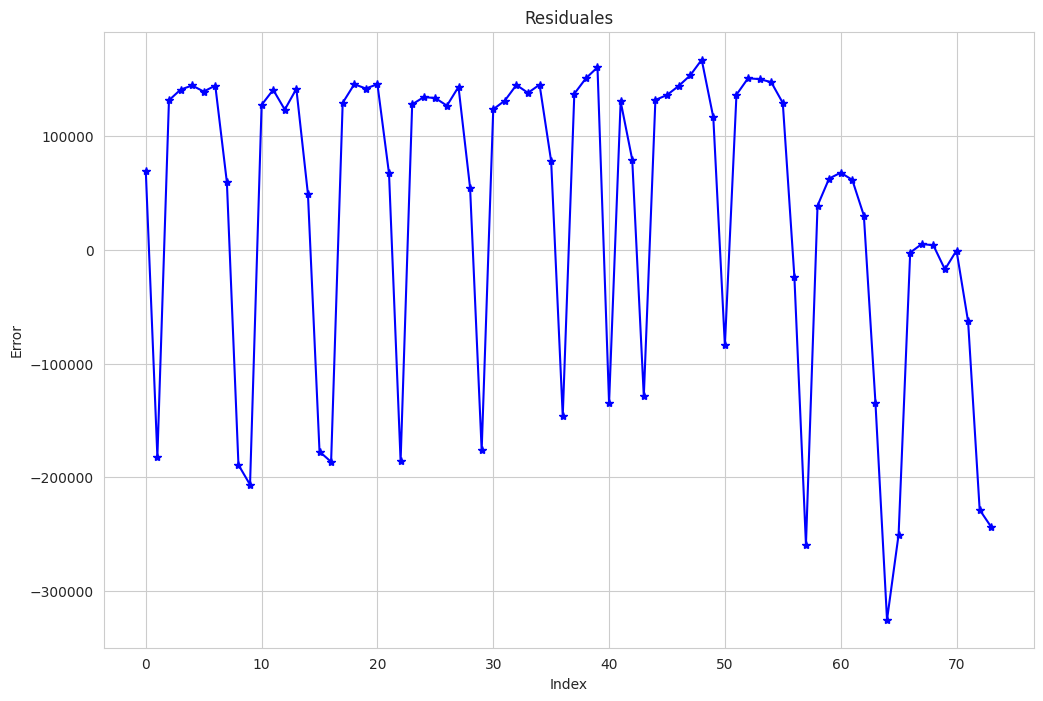

In [72]:
plt.figure(figsize=(12, 8))
plt.plot(range(Residuales.size), Residuales, linestyle='-', marker='*', color='b')
plt.title('Residuales')
plt.ylabel('Error')
plt.xlabel('Index')

**COMPARACIÓN CAPACIDAD PREDICTIVA**

**ECM SARIMA:**143714

**ECM REDES NEURONALES:** 193350

**ECM ÁRBOLES DE DECISIÓN:** 85519